In [1]:
# Author: Arthur Mensch <arthur.mensch@m4x.org>
# License: BSD 3 clause

import time
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
import f3dasm
import tensorflow as tf
from tensorflow import keras


2023-05-02 14:57:27,031 - Imported f3dasm (version: 1.1.0)
2023-05-02 14:57:27.302762: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 14:57:27.443027: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-02 14:57:28.082846: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.1/lib64:/

In [2]:
def accuracy(Y_pred, Y_true):
    # Create loss object
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    return loss(Y_true, Y_pred)


In [3]:
# Turn down for faster convergence
t0 = time.time()
train_samples = 5000

class MNISTData(f3dasm.data.LearningData):
    def __init__(self, X=None, y=None, seed=0):
        self.X = X
        self.y = y
        self.seed = seed
        self._create()

    def _create(self):

        if self.X is not None and self.y is not None:
            return

        # Load data from https://www.openml.org/d/554
        self.X, self.y = fetch_openml(
            "mnist_784", version=1, return_X_y=True, as_frame=False)

        random_state = check_random_state(self.seed)
        permutation = random_state.permutation(self.X.shape[0])

        self.X = self.X[permutation]
        self.X = self.X.reshape((self.X.shape[0], -1))
        
        self.y = self.y[permutation]
        self.y = self.y.astype(int)

    def get_input_data(self) -> np.ndarray:  # size = (n, dim)
        return self.X

    def get_labels(self) -> np.ndarray:  # size = (n, 1)
        return self.y

    def train_test_split(self, test_size):
        X_train, X_test, y_train, y_test = train_test_split(
    self.get_input_data(), self.get_labels(), test_size=test_size)
        return type(self)(X=X_train, y=y_train), type(self)(X=X_test, y=y_test)



In [4]:
mnist_clf = f3dasm.machinelearning.MNISTClassifier(dimensionality=28*28)

2023-05-02 14:57:38.006068: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-05-02 14:57:38.006166: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (martin): /proc/driver/nvidia/version does not exist
2023-05-02 14:57:38.007285: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# w = np.random.random(size=(101770,))

In [6]:
# mnist_clf.set_model_weights(w)

In [7]:
np.arange(len(mnist_clf.get_model_weights()))

array([     0,      1,      2, ..., 101767, 101768, 101769])

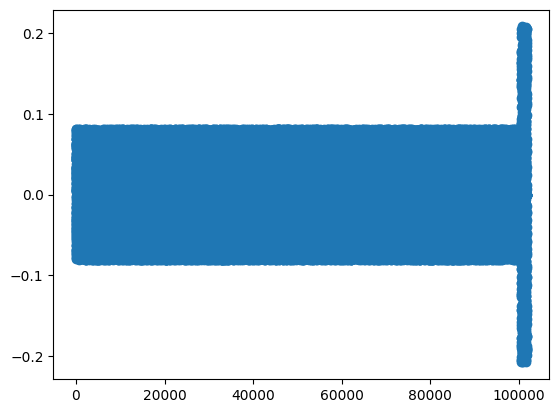

In [8]:
plt.scatter(x=np.arange(len(mnist_clf.get_model_weights())), y=mnist_clf.get_model_weights())

In [9]:
mnist_data = MNISTData()

In [10]:
y_pred = mnist_clf(mnist_data.get_input_data())
y_pred.shape

TensorShape([70000, 10])

In [11]:
data_train, data_test = mnist_data.train_test_split(test_size=0.2)

In [12]:
data_train.get_labels().shape, data_test.get_labels().shape

((56000,), (14000,))

In [13]:
scaler = StandardScaler()

X_train = scaler.fit_transform(data_train.get_input_data())
X_test = scaler.transform(data_test.get_input_data())

data_train.X = X_train

In [14]:
evaluator = f3dasm.machinelearning.Evaluator(model=mnist_clf, learning_data=data_train, loss_function=accuracy)

In [32]:
y_train_pred = mnist_clf(data_train.get_input_data())
y_train_true = tf.constant(data_train.get_labels())
labels = tf.reshape(y_train_true, [-1,1])

accuracy(Y_pred=y_train_true, Y_true=labels)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss(labels, y_train_pred)

# labels, y_train_pred

ValueError: `labels.shape` must equal `logits.shape` except for the last dimension. Received: labels.shape=(56000,) and logits.shape=(1, 56000)

In [15]:
w = np.random.random(size=(101770,))
w

array([0.88635527, 0.64205404, 0.06186633, ..., 0.27575855, 0.24122479,
       0.08795934])

In [16]:
w0 = mnist_clf.get_model_weights()
w0

array([ 0.06923068, -0.07836026, -0.03468481, ...,  0.        ,
        0.        ,  0.        ], dtype=float32)

In [17]:
evaluator.evaluate(weights=w0)

tf.Tensor(2.76823, shape=(), dtype=float32)


AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'flatten'

In [ ]:
mnist_clf(X_train)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Turn up tolerance for faster convergence
clf = LogisticRegression(C=50.0 / train_samples, penalty="l1", solver="saga", tol=0.1)
clf.fit(X_train, y_train)
sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(X_test, y_test)
# print('Best C % .4f' % clf.C_)
print("Sparsity with L1 penalty: %.2f%%" % sparsity)
print("Test score with L1 penalty: %.4f" % score)

coef = clf.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(
        coef[i].reshape(28, 28),
        interpolation="nearest",
        cmap=plt.cm.RdBu,
        vmin=-scale,
        vmax=scale,
    )
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel("Class %i" % i)
plt.suptitle("Classification vector for...")

run_time = time.time() - t0
print("Example run in %.3f s" % run_time)
plt.show()

In [ ]:
X_train.shape